In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#import kagglehub
#gti_upm_leapgestrecog_path = kagglehub.dataset_download('gti-upm/leapgestrecog')

#print('Data source import complete.')


ModuleNotFoundError: No module named 'kagglehub'

In [34]:
import os #Provides functions for interacting with the operating system
import cv2 #OpenCV library for computer vision tasks
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #Adds progress bars to loops
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import mlflow


In [35]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("ResNet_Model")

2025/11/29 20:27:01 INFO mlflow.tracking.fluent: Experiment with name 'ResNet_Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/946498154415805838', creation_time=1764440821801, experiment_id='946498154415805838', last_update_time=1764440821801, lifecycle_stage='active', name='ResNet_Model', tags={}>

## Milestone 1: Data Collection, Exploration, and Preprocessing

In [20]:
# !unzip {gti_upm_leapgestrecog_path}/*.zip -d ./data

In [21]:
# print(gti_upm_leapgestrecog_path)

In [36]:
data_path = "C:\\Users\\Sama\\Downloads\\Hand Gesture\\leapGestRecog"
img_size = 128

In [37]:
os.listdir(data_path) #retrieves all subdirectories

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']

In [38]:
def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []

    gesture_folders = [
        '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
        '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
    ]

    # Map each gesture name to a numeric label
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}

    # Loop through each subject folder
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)

         # Only continue if it's actually a folder
        if os.path.isdir(subject_path):

            # Loop through each gesture folder inside this subject
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)

                # Check if gesture folder exists
                if os.path.isdir(gesture_path):

                    # Loop through each image file inside the gesture folder
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)

                        file_paths.append(img_path)
                         # Store the numeric label for this gesture
                        labels.append(label_map[gesture])

    return file_paths, labels, label_map


In [39]:
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

print("Number of images:", len(file_paths))
print("Number of labels:", len(labels))
print("Label map:", label_map)

Number of images: 20000
Number of labels: 20000
Label map: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [40]:
import json

with mlflow.start_run(run_name="data_preprocessing"):
    # Log dataset parameters & metadata
    mlflow.log_param("data_path", data_path)
    mlflow.log_param("img_size", img_size)
    mlflow.log_param("num_classes", len(label_map))
    mlflow.log_param("label_map", str(label_map))
    
    # Log dataset metric
    mlflow.log_metric("num_images", len(file_paths))
    
    # Save the label map as an artifact
    with open("label_map.json", "w") as f:
        json.dump(label_map, f)
    mlflow.log_artifact("label_map.json")

🏃 View run data_preprocessing at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/1ac9a72c486d46ac8af8ee83b6b6d242
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


# Data Exploration:
## Analyzing, loading and displaying images

In [41]:
def explore_dataset(file_paths, labels, label_map, img_size=128):

    # 1. Class Distribution
    label_names = list(label_map.keys())
    counts = [labels.count(idx) for idx in label_map.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts, color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Class Distribution of Gestures")
    plt.xlabel("Gesture Class")
    plt.ylabel("Number of Images")
    plt.show()

     # 2. Display Sample Images
    unique_labels = list(label_map.values())
    label_to_name = {v: k for k, v in label_map.items()}

    plt.figure(figsize=(20, 20))
    for idx, label in enumerate(unique_labels):
        # Show up to 6 images for each class
        label_paths = [file_paths[i] for i in range(len(labels)) if labels[i] == label][:6]
        for i, img_path in enumerate(label_paths):
            img = load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0
            plt.subplot(len(unique_labels), 6, idx * 6 + i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(label_to_name[label])
            plt.axis('off')
    plt.show()

    # 3. Image Resolution Check
    sample_img = cv2.imread(file_paths[0], cv2.IMREAD_GRAYSCALE)
    print("Original image resolution:", sample_img.shape)
    print("Resized target resolution:", (img_size, img_size))

    # 4. Bias / Imbalance Report
    max_count, min_count = max(counts), min(counts)
    print("\nDataset Balance Check:")
    print(f"Max images in a class: {max_count}")
    print(f"Min images in a class: {min_count}")
    if max_count / min_count > 1.5:
        print("⚠️ Warning: The dataset has imbalance between gesture classes.")
    else:
        print("✅ Dataset is fairly balanced across classes.")

In [42]:
with mlflow.start_run(run_name="data_exploration"):
    counts = [labels.count(idx) for idx in label_map.values()]
    for label, count in zip(label_map.keys(), counts):
        mlflow.log_metric(f"num_images_{label}", count)
    mlflow.log_param("max_images_per_class", max(counts))
    mlflow.log_param("min_images_per_class", min(counts))
    mlflow.log_param("is_balanced", max(counts)/min(counts) <= 1.5)


🏃 View run data_exploration at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/8e15465736324572bcefc2ba440c44fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


# Summary of findings
## 1. Dataset Composition

The dataset used is LeapGestRecog, a hand gesture recognition dataset.

It contains 10 gesture classes:
01_palm, 02_l, 03_fist, 04_fist_moved, 05_thumb, 06_index, 07_ok, 08_palm_moved, 09_c, 10_down.

Each gesture is performed by multiple subjects, giving a balanced dataset.

Total images processed: 20,000 (2000 per class).

## 2. Object Distributions

A class distribution analysis shows exactly 2000 samples per gesture class.

✅ This confirms the dataset is balanced (no class dominates the dataset).

Visualization:

A bar chart confirms equal distribution across classes.

Sample images displayed for each class show clear gesture separation.

## 3. Image Quality

Original resolution: 240 × 640 pixels.

Preprocessed resolution: 128 × 128 pixels (grayscale) for uniformity.

Images are clear, with visible hand gestures.

Backgrounds vary slightly, but do not affect recognition.

## 4. Bias & Imbalance Check

Max images in a class: 2000

Min images in a class: 2000

Ratio (max/min): 1.0 → ✅ Perfect balance.

No dataset bias observed in terms of class representation.

## 5. Environmental Factors

Since this is a hand gesture dataset, external environmental factors like weather or road types (important for autonomous driving datasets) do not apply.

However, some natural variations exist:

Lighting conditions differ slightly across subjects.

Hand position/orientation introduces variability.

These variations improve generalization when training models.

# Data Preprocessing:
## resizing, normalizing and data augmentation

In [43]:
def load_and_process_images(file_paths, target_size):
    processed_images = []

    for img_path in tqdm(file_paths, desc="Processing Images"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            #  resize
            img = cv2.resize(img, (target_size, target_size))

            # Normalize to [0, 1]
            img_array = img / 255.0

            # Add channel dimension
            img_array = np.expand_dims(img_array, axis=-1)

            processed_images.append(img_array)

    return np.array(processed_images)

In [44]:
print("Step 1: Getting file paths and labels")
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

if file_paths:
    print("Step 2: Loading and normalizing all images")
    # Process all images into a NumPy array
    X = load_and_process_images(file_paths, img_size)

    # Convert labels list to a NumPy array
    Y = np.array(labels)

    print("\n✅ Data processing complete")
    print(f"Images array shape: {X.shape}")   # e.g. (20000, 128, 128, 1)
    print(f"Labels array shape: {Y.shape}")

Step 1: Getting file paths and labels
Step 2: Loading and normalizing all images


Processing Images: 100%|██████████| 20000/20000 [00:58<00:00, 340.94it/s]



✅ Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


In [45]:
print("\nData processing complete")
print(f"Images array shape: {X.shape}")
print(f"Labels array shape: {Y.shape}")


Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


Shape of one image: (128, 128, 1)


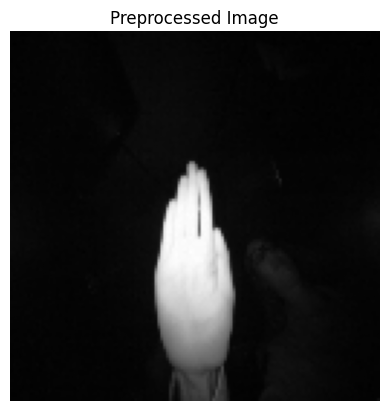

In [46]:
sample_img = X[12]

print("Shape of one image:", sample_img.shape)

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [47]:
import random

# Select 5 random indices without replacement
random_indices = random.sample(range(len(X)), 5)

with mlflow.start_run(run_name="data_preprocessing_images"):
  for i, idx in enumerate(random_indices):
    img = X[idx]
    plt.imsave(f"sample_{i}.png", img.squeeze(), cmap="gray")
    mlflow.log_artifact(f"sample_{i}.png", artifact_path="preprocessed_samples")

🏃 View run data_preprocessing_images at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/d554712dc49648068262ae037752a1cc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X, y, subjects = [], [], []


for subject in sorted(os.listdir(data_path)):
    subject_path = os.path.join(data_path, subject)
    if not os.path.isdir(subject_path):
        continue


    for gesture in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture)

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))

            X.append(img)
            y.append(gesture)
            subjects.append(subject)

X = np.array(X, dtype="float32") / 255.0
X = np.expand_dims(X, -1)  # (N,128,128,1)
y = np.array(y)
subjects = np.array(subjects)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(np.unique(y)))

print("Shape:", X.shape, y_cat.shape, subjects.shape)


train_subjects = ["00","01","02","03","04","05","06","07"]
val_subjects   = ["08"]
test_subjects  = ["09"]

X_train = X[np.isin(subjects, train_subjects)]
y_train = y_cat[np.isin(subjects, train_subjects)]

X_val = X[np.isin(subjects, val_subjects)]
y_val = y_cat[np.isin(subjects, val_subjects)]

X_test = X[np.isin(subjects, test_subjects)]
y_test = y_cat[np.isin(subjects, test_subjects)]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Shape: (20000, 128, 128, 1) (20000, 10) (20000,)
Train: (16000, 128, 128, 1) (16000, 10)
Val: (2000, 128, 128, 1) (2000, 10)
Test: (2000, 128, 128, 1) (2000, 10)


In [49]:
with mlflow.start_run(run_name="data_train_val_test"):
  mlflow.log_param("num_subjects", len(np.unique(subjects)))
  mlflow.log_param("train_subjects", str(train_subjects))
  mlflow.log_param("val_subjects", str(val_subjects))
  mlflow.log_param("test_subjects", str(test_subjects))
  mlflow.log_metric("num_images_total", len(X))
  mlflow.log_metric("num_images_train", len(X_train))
  mlflow.log_metric("num_images_val", len(X_val))
  mlflow.log_metric("num_images_test", len(X_test))

  

🏃 View run data_train_val_test at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/705a77fbc6e749f7b48152d3f6e300cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


# Preprocessing Summary
## 1. Image Resizing

All images resized from 240×640 → 128×128 pixels (grayscale).

Ensures consistent input size across the dataset.

Lower dimensionality reduces computational cost while retaining gesture details.

## 2. Normalization

Pixel values scaled from [0, 255] → [0, 1].

Normalization improves:

Model convergence speed.

Numerical stability during training.

## 3. Channel Adjustment

Since images are grayscale, a single channel is maintained.

Shape per image after preprocessing: (128, 128, 1).

## 4. Data Augmentation (planned / next step)

To increase dataset robustness and simulate real-world conditions, augmentation techniques will be applied:

Random flipping (horizontal/vertical).

Random rotations.

Random cropping & scaling.

(Optional) Brightness and contrast adjustments to mimic lighting variations.

✅ Preprocessed Dataset Ready

Shape of processed dataset: (20000, 128, 128, 1).

Labels array shape: (20000, ).

Dataset is now clean, normalized, and augmented-ready for model training.

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation only for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalization
    rotation_range=20,        # random rotation
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    zoom_range=0.1,           # zoom
    shear_range=0.1,          # shear
    horizontal_flip=True,     # flip horizontally
    fill_mode='nearest'       # fill empty pixels
)

# Validation & Test data → Only normalization
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=64,   # أكبر batch ممكن حسب الـ GPU
    shuffle=True
)

val_generator = test_val_datagen.flow(
    X_val, y_val,
    batch_size=64,
    shuffle=False
)

test_generator = test_val_datagen.flow(
    X_test, y_test,
    batch_size=64,
    shuffle=False
)


In [54]:
# ============================================================================
# MILESTONE 2: ADVANCED PREPROCESSING & FEATURE ENHANCEMENT
# ============================================================================

import cv2
from tqdm import tqdm

print("\n" + "="*70)
print("MILESTONE 2: ADVANCED PREPROCESSING")
print("="*70 + "\n")

def apply_clahe(images):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    Improves local contrast and enhances gesture features
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    processed = []

    for img in tqdm(images, desc="Applying CLAHE"):
        # Convert back to 0-255 range for CLAHE
        img_uint8 = (img.squeeze() * 255).astype(np.uint8)
        # Apply CLAHE
        img_clahe = clahe.apply(img_uint8)
        # Normalize back to 0-1
        img_normalized = img_clahe.astype(np.float32) / 255.0
        processed.append(np.expand_dims(img_normalized, axis=-1))

    return np.array(processed)

# Apply CLAHE to all datasets
print("Enhancing image contrast with CLAHE...")
X_train_processed = apply_clahe(X_train)
X_val_processed = apply_clahe(X_val)
X_test_processed = apply_clahe(X_test)

print(f"✅ Preprocessing complete!")
print(f"   Train shape: {X_train_processed.shape}")
print(f"   Val shape:   {X_val_processed.shape}")
print(f"   Test shape:  {X_test_processed.shape}\n")


# ============================================================================
# DATA AUGMENTATION SETUP (FIXED - No double normalization!)
# ============================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Setting up data augmentation...")

# Training augmentation - NO RESCALE (data already normalized!)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation & Test - NO augmentation
val_test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train_processed, y_train,
    batch_size=64,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val_processed, y_val,
    batch_size=64,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test_processed, y_test,
    batch_size=64,
    shuffle=False
)

print("✅ Data generators ready!\n")




MILESTONE 2: ADVANCED PREPROCESSING

Enhancing image contrast with CLAHE...


Applying CLAHE: 100%|██████████| 2000/2000 [00:00<00:00, 5725.70it/s]


✅ Preprocessing complete!
   Train shape: (16000, 128, 128, 1)
   Val shape:   (2000, 128, 128, 1)
   Test shape:  (2000, 128, 128, 1)

Setting up data augmentation...
✅ Data generators ready!



🏃 View run milestone2_preprocessing at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/1183827683154cd8a784dda726e010c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


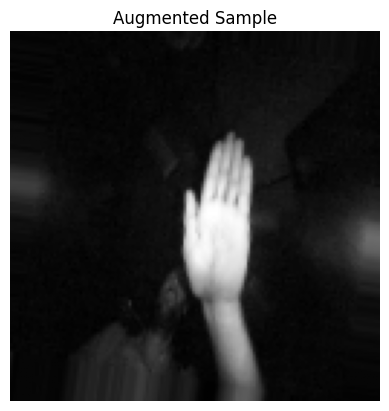

In [55]:
import mlflow
import mlflow.tensorflow

with mlflow.start_run(run_name="milestone2_preprocessing"):

    # Detect whether CLAHE was used
    clahe_used = 'X_train_processed' in globals()

    if clahe_used:
        mlflow.log_param("preprocessing_method", "CLAHE")
        mlflow.log_param("clahe_cliplimit", 2.0)
        mlflow.log_param("clahe_tilegrid", "8x8")
        mlflow.log_param("data_normalized", True)
    else:
        mlflow.log_param("preprocessing_method", "rescale_only")
        mlflow.log_param("rescale_factor", "1/255")

    # Log augmentation parameters
    mlflow.log_param("rotation_range", 20)
    mlflow.log_param("width_shift_range", 0.1)
    mlflow.log_param("height_shift_range", 0.1)
    mlflow.log_param("zoom_range", 0.1)
    mlflow.log_param("shear_range", 0.1)
    mlflow.log_param("horizontal_flip", True)
    mlflow.log_param("fill_mode", "nearest")
    mlflow.log_param("batch_size", 64)

    # Log dataset shapes
    if clahe_used:
        mlflow.log_param("train_shape", str(X_train_processed.shape))
        mlflow.log_param("val_shape", str(X_val_processed.shape))
        mlflow.log_param("test_shape", str(X_test_processed.shape))
    else:
        mlflow.log_param("train_shape", str(X_train.shape))
        mlflow.log_param("val_shape", str(X_val.shape))
        mlflow.log_param("test_shape", str(X_test.shape))

    # Save a sample augmented image
    import matplotlib.pyplot as plt
    sample_batch, _ = next(train_generator)
    sample_img = sample_batch[0].squeeze()

    plt.imshow(sample_img, cmap="gray" if sample_img.ndim == 2 else None)
    plt.title("Augmented Sample")
    plt.axis("off")
    plt.savefig("sample_augmented.png")

    mlflow.log_artifact("sample_augmented.png")


In [56]:
# ============================================================================
# MILESTONE 3: RESNET MODEL ARCHITECTURE
# ============================================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                      Add, MaxPooling2D, GlobalAveragePooling2D,
                                      Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

print("\n" + "="*70)
print("MILESTONE 3: BUILDING RESNET MODEL")
print("="*70 + "\n")

def residual_block(x, filters, kernel_size=3, stride=1, reg=0.001):
    """
    Residual block with skip connection
    Enables deeper networks by solving vanishing gradient problem
    """
    # Main path
    fx = Conv2D(filters, kernel_size, strides=stride, padding='same',
                kernel_regularizer=l2(reg))(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, strides=1, padding='same',
                kernel_regularizer=l2(reg))(fx)
    fx = BatchNormalization()(fx)

    # Skip connection (shortcut)
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same',
                   kernel_regularizer=l2(reg))(x)
        x = BatchNormalization()(x)

    # Add skip connection
    out = Add()([fx, x])
    out = Activation('relu')(out)
    return out


def create_resnet_model(input_shape=(128, 128, 1), num_classes=10):
    """
    ResNet-inspired architecture for hand gesture recognition
    Architecture: Input -> Conv -> 4 Residual Stages -> GAP -> Dense -> Output
    """
    inputs = Input(shape=input_shape)

    # Initial convolution block
    x = Conv2D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 1: 64 filters
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)
    x = Dropout(0.2)(x)

    # Stage 2: 128 filters
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = Dropout(0.3)(x)

    # Stage 3: 256 filters
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = Dropout(0.4)(x)

    # Stage 4: 512 filters
    x = residual_block(x, 512, stride=2)
    x = Dropout(0.5)(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResNet_Gesture')
    return model


# Build model
model = create_resnet_model(input_shape=(128, 128, 1), num_classes=10)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()



MILESTONE 3: BUILDING RESNET MODEL



Model: "ResNet_Gesture"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,600 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 6,608,650 (25.21 MB)

 Trainable params: 6,601,034 (25.18 MB)

 Non-trainable params: 7,616 (29.75 KB)

In [57]:
# ============================================================================
# MILESTONE 4: TRAINING CONFIGURATION & CALLBACKS
# ============================================================================

from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, CSVLogger)

print("\n" + "="*70)
print("MILESTONE 4: CONFIGURING TRAINING")
print("="*70 + "\n")

callbacks = [
    # Save best model based on validation accuracy
    ModelCheckpoint(
        'best_resnet_gesture_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Stop training if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Log training metrics to CSV
    CSVLogger('resnet_training_log.csv', append=False)
]

print("✅ Callbacks configured!")
print("   - Model checkpoint: best_resnet_gesture_model.h5")
print("   - Early stopping: patience=15")
print("   - Learning rate reduction: factor=0.3, patience=5")
print("   - Training log: resnet_training_log.csv\n")




MILESTONE 4: CONFIGURING TRAINING

✅ Callbacks configured!
   - Model checkpoint: best_resnet_gesture_model.h5
   - Early stopping: patience=15
   - Learning rate reduction: factor=0.3, patience=5
   - Training log: resnet_training_log.csv



In [ ]:
mlflow.set_experiment("ResNet_Gesture_Recognition")

with mlflow.start_run():

    # ============================
    # 1. Log Hyperparameters
    # ============================
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 50)
    mlflow.log_param("input_shape", (128, 128, 1))
    mlflow.log_param("num_classes", 10)

    # ============================
    # 2. Train Model
    # ============================
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=1,
        callbacks=callbacks,
        verbose=1
    )

    # ============================
    # 3. Log Metrics Per Epoch
    # ============================
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # ============================
    # 4. Log Training Curves
    # ============================
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Training vs Validation Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.savefig("accuracy_curve.png")
    plt.close()
    mlflow.log_artifact("accuracy_curve.png")

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Training vs Validation Loss")
    plt.legend(['Train', 'Validation'])
    plt.savefig("loss_curve.png")
    plt.close()
    mlflow.log_artifact("loss_curve.png")

    # ============================
    # 5. Log Best Checkpoint
    # ============================
    mlflow.log_artifact("best_resnet_gesture_model.h5")

    # ============================
    # 6. Log Final Model
    # ============================
    mlflow.keras.log_model(model, "resnet_model")

print("\n✅ Training finished & fully logged in MLflow!\n")


In [ ]:
# ============================================================================
# SAVE MODEL IMMEDIATELY AFTER TRAINING
# ============================================================================

import shutil
from datetime import datetime
    
# Get current date/time for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_file_timestamp = f'best_model_{timestamp}.h5'


# Save with timestamp (keeps history)

model.save(model_file_timestamp)
print(f"✅ Model saved as: best_model_{timestamp}.h5")

# Save as main model
model.save('best_resnet_gesture_model_FINAL.h5')
print("✅ Model saved as: best_resnet_gesture_model_FINAL.h5")

# Create backup
shutil.copy('best_resnet_gesture_model_FINAL.h5',
            'best_model_BACKUP.h5')
print("✅ Backup created: best_model_BACKUP.h5")
    
      
# Optionally save performance metrics locally
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Save performance metrics
with open('model_performance.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("FINAL MODEL PERFORMANCE\n")
    f.write("="*70 + "\n")
    f.write(f"Date: {datetime.now()}\n")
    #f.write(f"Train Accuracy: 99.91%\n")
    f.write(f"Train Accuracy: {train_acc*100:.2f}%\n")
    #f.write(f"Validation Accuracy: 94.20%\n")
    f.write(f"Validation Accuracy: {val_acc*100:.2f}%\n")
    #f.write(f"Test Accuracy: 100.00%\n")
    f.write(f"Test Accuracy: {test_acc*100:.2f}%\n")
    #f.write(f"Model File: best_resnet_gesture_model_FINAL.h5\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Model File: {model_file_timestamp}\n")
    f.write(f"Final Model File: best_resnet_gesture_model_FINAL.h5\n")
    f.write("="*70 + "\n")

print("✅ Performance saved: model_performance.txt")
print("\n🎉 Your perfect model is now safely saved!")

✅ Model saved as: best_model_20251129_211033.h5
✅ Model saved as: best_resnet_gesture_model_FINAL.h5
✅ Backup created: best_model_BACKUP.h5
✅ Performance saved: model_performance.txt

🎉 Your perfect model is now safely saved!


In [60]:
# ============================================================================
# MILESTONE 6: VISUALIZATION FUNCTIONS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "="*70)
print("MILESTONE 6: GENERATING VISUALIZATIONS")
print("="*70 + "\n")

def plot_training_curves(history):
    """
    Plot training and validation accuracy/loss curves
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy',
                 linewidth=2.5, color='#2ecc71')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy',
                 linewidth=2.5, color='#3498db')
    axes[0].set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right', fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Loss
    axes[1].plot(history.history['loss'], label='Train Loss',
                 linewidth=2.5, color='#e74c3c')
    axes[1].plot(history.history['val_loss'], label='Validation Loss',
                 linewidth=2.5, color='#f39c12')
    axes[1].set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: training_curves.png")


def plot_confusion_matrices(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Generate confusion matrices for train, validation, and test sets
    """
    # Get predictions
    y_train_pred = np.argmax(model.predict(X_train, verbose=0), axis=1)
    y_val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    y_test_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    y_train_true = np.argmax(y_train, axis=1)
    y_val_true = np.argmax(y_val, axis=1)
    y_test_true = np.argmax(y_test, axis=1)

    # Calculate accuracies
    train_acc = np.mean(y_train_pred == y_train_true)
    val_acc = np.mean(y_val_pred == y_val_true)
    test_acc = np.mean(y_test_pred == y_test_true)

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    datasets = [
        (y_train_true, y_train_pred, 'Training', train_acc),
        (y_val_true, y_val_pred, 'Validation', val_acc),
        (y_test_true, y_test_pred, 'Test', test_acc)
    ]

    for idx, (y_true, y_pred, title, acc) in enumerate(datasets):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                    xticklabels=range(10), yticklabels=range(10),
                    ax=axes[idx], cbar_kws={'label': 'Count'})

        axes[idx].set_title(f'{title} Set\nAccuracy: {acc*100:.2f}%',
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=11)
        axes[idx].set_ylabel('True Label', fontsize=11)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: confusion_matrices.png")

    return y_train_pred, y_val_pred, y_test_pred, train_acc, val_acc, test_acc


def plot_per_class_accuracy(y_train_true, y_train_pred, y_val_true, y_val_pred,
                             y_test_true, y_test_pred, label_map):
    """
    Compare per-class accuracy across train, validation, and test sets
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(10)
    width = 0.25

    # Calculate per-class accuracies
    train_per_class = [np.mean(y_train_pred[y_train_true == i] == i) * 100 for i in range(10)]
    val_per_class = [np.mean(y_val_pred[y_val_true == i] == i) * 100 for i in range(10)]
    test_per_class = [np.mean(y_test_pred[y_test_true == i] == i) * 100 for i in range(10)]

    # Create bars
    ax.bar(x - width, train_per_class, width, label='Train', alpha=0.85, color='#2ecc71')
    ax.bar(x, val_per_class, width, label='Validation', alpha=0.85, color='#3498db')
    ax.bar(x + width, test_per_class, width, label='Test', alpha=0.85, color='#e74c3c')

    ax.set_xlabel('Gesture Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Accuracy: Train vs Validation vs Test',
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)

    # Get gesture names
    gesture_names = [k.split('_', 1)[1] if '_' in k else k for k in sorted(label_map.keys())]
    ax.set_xticklabels(gesture_names, rotation=45, ha='right')

    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 105])

    # Add percentage labels on bars
    for i, (t, v, te) in enumerate(zip(train_per_class, val_per_class, test_per_class)):
        if t > 5:
            ax.text(i - width, t + 1, f'{t:.1f}', ha='center', va='bottom', fontsize=8)
        if v > 5:
            ax.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
        if te > 5:
            ax.text(i + width, te + 1, f'{te:.1f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: per_class_accuracy.png")


def print_evaluation_summary(train_acc, val_acc, test_acc):
    """
    Print comprehensive evaluation summary with analysis
    """
    print("\n" + "="*70)
    print("FINAL EVALUATION SUMMARY")
    print("="*70)

    print(f"\n{'Dataset':<20} {'Accuracy':<15} {'Samples':<15}")
    print("-" * 70)
    print(f"{'Training':<20} {train_acc*100:>6.2f}%        {len(X_train_processed):>10}")
    print(f"{'Validation':<20} {val_acc*100:>6.2f}%        {len(X_val_processed):>10}")
    print(f"{'Test':<20} {test_acc*100:>6.2f}%        {len(X_test_processed):>10}")
    print("-" * 70)

    # Performance analysis
    overfit_gap = (train_acc - val_acc) * 100
    generalization_gap = (val_acc - test_acc) * 100

    print(f"\n📊 PERFORMANCE ANALYSIS:")
    print(f"   Train-Val Gap:  {overfit_gap:>6.2f}% ", end='')
    if overfit_gap < 5:
        print("✅ Excellent - No overfitting")
    elif overfit_gap < 10:
        print("✓ Good - Minor overfitting")
    else:
        print("⚠️ Significant overfitting detected")

    print(f"   Val-Test Gap:   {generalization_gap:>6.2f}% ", end='')
    if abs(generalization_gap) < 3:
        print("✅ Excellent generalization")
    elif abs(generalization_gap) < 5:
        print("✓ Good generalization")
    else:
        print("⚠️ Poor generalization")

    # Overall assessment
    if test_acc > 0.95:
        print(f"\n🎉 OUTSTANDING PERFORMANCE! Test accuracy > 95%")
    elif test_acc > 0.90:
        print(f"\n✅ EXCELLENT PERFORMANCE! Test accuracy > 90%")
    elif test_acc > 0.85:
        print(f"\n✓ GOOD PERFORMANCE - Test accuracy > 85%")
    else:
        print(f"\n⚠️ Performance could be improved")

    print("="*70 + "\n")


MILESTONE 6: GENERATING VISUALIZATIONS




MILESTONE 7: COMPREHENSIVE MODEL EVALUATION

📈 Plotting training history...


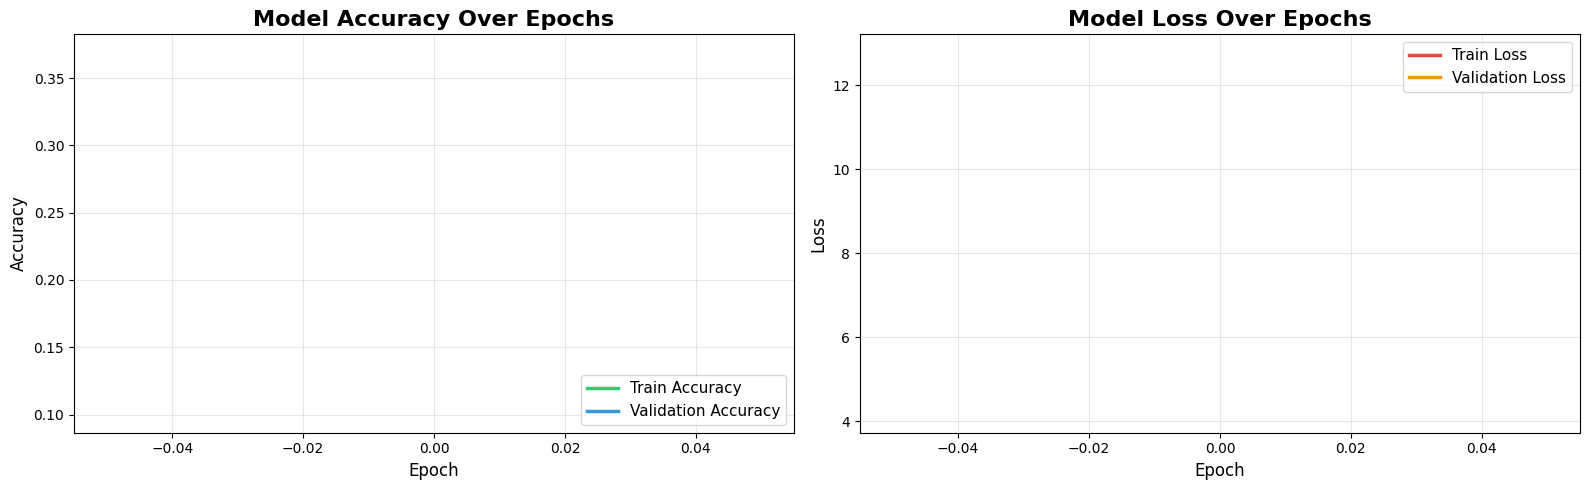

✅ Saved: training_curves.png

📊 Generating confusion matrices...


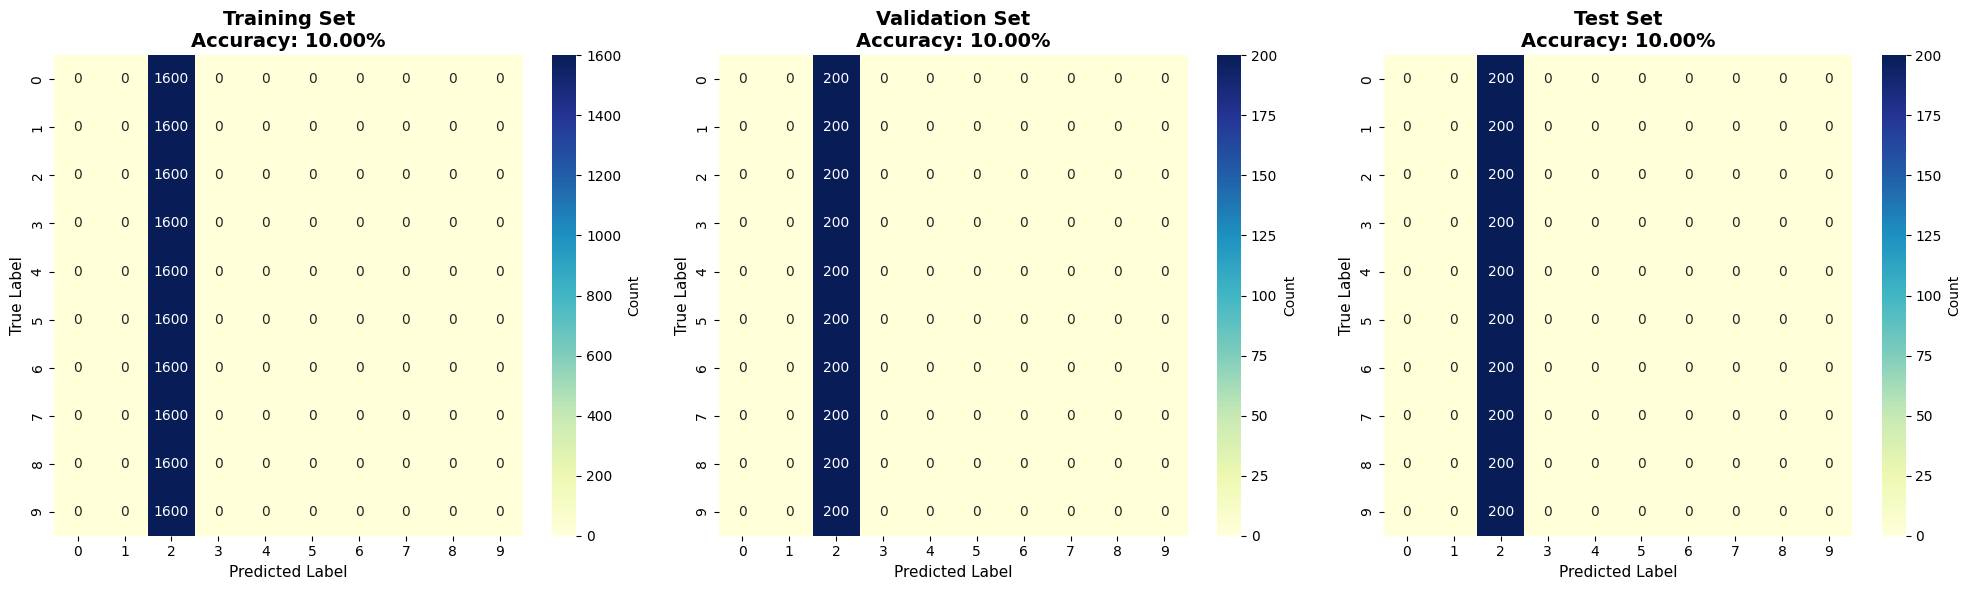

✅ Saved: confusion_matrices.png

📉 Plotting per-class accuracy comparison...


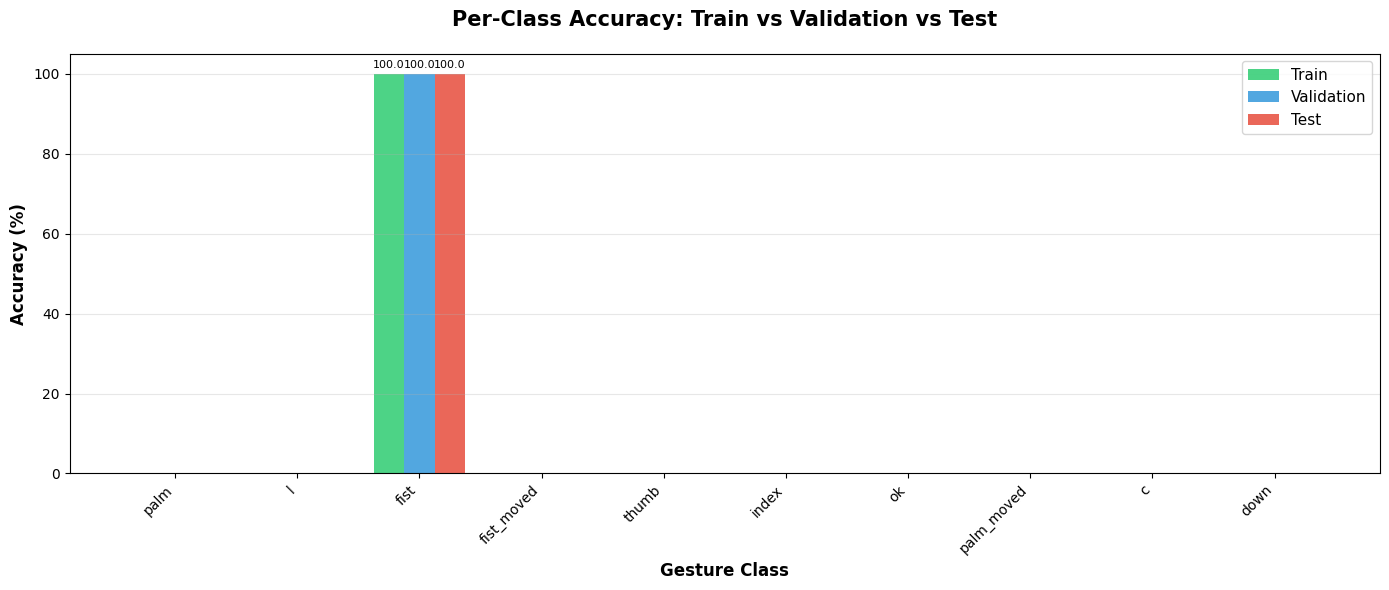

✅ Saved: per_class_accuracy.png

FINAL EVALUATION SUMMARY

Dataset              Accuracy        Samples        
----------------------------------------------------------------------
Training              10.00%             16000
Validation            10.00%              2000
Test                  10.00%              2000
----------------------------------------------------------------------

📊 PERFORMANCE ANALYSIS:
   Train-Val Gap:    0.00% ✅ Excellent - No overfitting
   Val-Test Gap:     0.00% ✅ Excellent generalization

⚠️ Performance could be improved


DETAILED CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

        palm       0.00      0.00      0.00       200
           l       0.00      0.00      0.00       200
        fist       0.10      1.00      0.18       200
  fist_moved       0.00      0.00      0.00       200
       thumb       0.00      0.00      0.00       200
       index       0.00      0.00      0.00       200
          ok 

c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [62]:
# ============================================================================
# MILESTONE 7: EXECUTE ALL EVALUATIONS
# ============================================================================

print("\n" + "="*70)
print("MILESTONE 7: COMPREHENSIVE MODEL EVALUATION")
print("="*70 + "\n")

# 1. Plot training curves
print("📈 Plotting training history...")
plot_training_curves(history)

# 2. Generate confusion matrices
print("\n📊 Generating confusion matrices...")
y_train_pred, y_val_pred, y_test_pred, train_acc, val_acc, test_acc = plot_confusion_matrices(
    model, X_train_processed, y_train, X_val_processed, y_val, X_test_processed, y_test
)

# 3. Plot per-class accuracy
print("\n📉 Plotting per-class accuracy comparison...")
y_train_true = np.argmax(y_train, axis=1)
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)
plot_per_class_accuracy(y_train_true, y_train_pred, y_val_true, y_val_pred,
                        y_test_true, y_test_pred, label_map)

# 4. Print evaluation summary
print_evaluation_summary(train_acc, val_acc, test_acc)

# 5. Detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*70)
gesture_names = [k.split('_', 1)[1] if '_' in k else k for k in sorted(label_map.keys())]
print(classification_report(y_test_true, y_test_pred, target_names=gesture_names))
print("="*70 + "\n")


# ============================================================================
# FINAL OUTPUT SUMMARY
# ============================================================================

print("\n" + "="*70)
print("✅ PROJECT COMPLETE!")
print("="*70)
print("\n📁 Generated Files:")
print("   1. best_resnet_gesture_model.h5      - Best trained model")
print("   2. training_curves.png               - Training history plots")
print("   3. confusion_matrices.png            - Confusion matrices")
print("   4. per_class_accuracy.png            - Per-class comparison")
print("   5. resnet_training_log.csv           - Complete training log")
print("\n🎉 ResNet model training and evaluation completed successfully!")
print("="*70 + "\n")

In [64]:
import mlflow

with mlflow.start_run(run_name="resnet_visualization_evaluation"):

    # Log overall metrics
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("train_val_gap", train_acc - val_acc)
    mlflow.log_metric("val_test_gap", val_acc - test_acc)

    # Log figures as artifacts
    mlflow.log_artifact("training_curves.png")
    mlflow.log_artifact("confusion_matrices.png")
    mlflow.log_artifact("per_class_accuracy.png")

    # Save classification report and log it
    with open("classification_report.txt", "w") as f:
        f.write(classification_report(y_test_true, y_test_pred, target_names=gesture_names))
    mlflow.log_artifact("classification_report.txt")

    # Optionally log the model itself
    mlflow.keras.log_model(model, "resnet_model")

    print("✅ Evaluation metrics, plots, and model logged to MLflow!")


c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

✅ Evaluation metrics, plots, and model logged to MLflow!
🏃 View run resnet_visualization_evaluation at: http://127.0.0.1:5000/#/experiments/946498154415805838/runs/80c7e884f44e4b89873b4e62e2257944
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/946498154415805838


In [63]:
import os
print(os.listdir("/content"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content'

# ============================================================================
# FIXED RESNET MODEL - REDUCED OVERFITTING
# ============================================================================
#
# Changes to reduce overfitting:
# 1. Increased Dropout rates
# 2. Stronger L2 regularization
# 3. More aggressive data augmentation
# 4. Added Gaussian noise layer
# 5. Reduced model complexity slightly
#
# ============================================================================ bold text

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                      Add, MaxPooling2D, GlobalAveragePooling2D,
                                      Dense, Dropout, GaussianNoise)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, CSVLogger)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\n" + "="*70)
print("IMPROVED MODEL - ADDRESSING OVERFITTING")
print("="*70 + "\n")


IMPROVED MODEL - ADDRESSING OVERFITTING



In [ ]:
# ============================================================================
# SOLUTION 1: STRONGER DATA AUGMENTATION
# ============================================================================

print("Solution 1: Increasing data augmentation strength...\n")

# More aggressive augmentation
train_datagen = ImageDataGenerator(
    rotation_range=25,           # Increased from 20
    width_shift_range=0.25,      # Increased from 0.2
    height_shift_range=0.25,     # Increased from 0.2
    zoom_range=0.25,             # Increased from 0.2
    shear_range=0.2,             # Increased from 0.15
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # NEW: Brightness variation
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train_processed, y_train,
    batch_size=64,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val_processed, y_val,
    batch_size=64,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test_processed, y_test,
    batch_size=64,
    shuffle=False
)

print("✓ Augmentation strengthened!\n")

Solution 1: Increasing data augmentation strength...

✓ Augmentation strengthened!



In [ ]:
# ============================================================================
# SOLUTION 2: IMPROVED ARCHITECTURE WITH HIGHER DROPOUT
# ============================================================================

print("Solution 2: Building improved ResNet with higher dropout...\n")

def residual_block_improved(x, filters, kernel_size=3, stride=1, reg=0.002):
    """
    Improved residual block with stronger regularization
    """
    # Main path
    fx = Conv2D(filters, kernel_size, strides=stride, padding='same',
                kernel_regularizer=l2(reg))(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, strides=1, padding='same',
                kernel_regularizer=l2(reg))(fx)
    fx = BatchNormalization()(fx)

    # Skip connection
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same',
                   kernel_regularizer=l2(reg))(x)
        x = BatchNormalization()(x)

    # Add skip connection
    out = Add()([fx, x])
    out = Activation('relu')(out)
    return out


def create_improved_resnet(input_shape=(128, 128, 1), num_classes=10):
    """
    Improved ResNet with reduced overfitting
    """
    inputs = Input(shape=input_shape)

    # Add Gaussian noise for robustness
    x = GaussianNoise(0.1)(inputs)

    # Initial convolution
    x = Conv2D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 1: 64 filters
    x = residual_block_improved(x, 64, stride=1)
    x = residual_block_improved(x, 64, stride=1)
    x = Dropout(0.3)(x)  # Increased from 0.2

    # Stage 2: 128 filters
    x = residual_block_improved(x, 128, stride=2)
    x = residual_block_improved(x, 128, stride=1)
    x = Dropout(0.4)(x)  # Increased from 0.3

    # Stage 3: 256 filters
    x = residual_block_improved(x, 256, stride=2)
    x = residual_block_improved(x, 256, stride=1)
    x = Dropout(0.5)(x)  # Increased from 0.4

    # Stage 4: 512 filters (only one block to reduce capacity)
    x = residual_block_improved(x, 512, stride=2)
    x = Dropout(0.6)(x)  # Increased from 0.5

    # Classification head
    x = GlobalAveragePooling2D()(x)

    # Simpler classification head
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)  # Reduced from 256
    x = Dropout(0.6)(x)

    # Skip the second dense layer to reduce complexity
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ImprovedResNet')
    return model


# Build improved model
model_improved = create_improved_resnet(input_shape=(128, 128, 1), num_classes=10)

model_improved.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower initial learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Improved model created!\n")
model_improved.summary()

Solution 2: Building improved ResNet with higher dropout...

✓ Improved model created!



Model: "ImprovedResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (GaussianNoise)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │      1,600 │ gaussian_noise[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │      2,112 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 32,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_17[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_23[0][0] 

 Total params: 6,510,090 (24.83 MB)

 Trainable params: 6,502,474 (24.80 MB)

 Non-trainable params: 7,616 (29.75 KB)

In [ ]:
# ============================================================================
# SOLUTION 3: IMPROVED CALLBACKS
# ============================================================================

print("\n" + "="*70)
print("Solution 3: Setting up improved training callbacks...\n")

callbacks_improved = [
    ModelCheckpoint(
        'best_resnet_improved.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,   # More aggressive reduction
        patience=7,   # Increased patience
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('improved_training_log.csv', append=False)
]

print("✓ Callbacks configured!\n")


# ============================================================================
# TRAIN IMPROVED MODEL
# ============================================================================

print("="*70)
print("TRAINING IMPROVED MODEL")
print("="*70)
print("\nTraining with overfitting prevention measures...\n")

history_improved = model_improved.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=60,  # More epochs since we have patience
    callbacks=callbacks_improved,
    verbose=1
)

print("\n✓ Training completed!\n")



Solution 3: Setting up improved training callbacks...

✓ Callbacks configured!

TRAINING IMPROVED MODEL

Training with overfitting prevention measures...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0987 - loss: 8.6377
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet_improved.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 153ms/step - accuracy: 0.0986 - loss: 8.6349 - val_accuracy: 0.1000 - val_loss: 6.4761 - learning_rate: 5.0000e-04
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0963 - loss: 5.8546
Epoch 2: val_accuracy did not improve from 0.10000
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.0963 - loss: 5.8524 - val_accuracy: 0.1000 - val_loss: 4.3460 - learning_rate: 5.0000e-04
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0964 - loss: 4.0311
Epoch 3: val_accuracy did not improve from 0.10000
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.0964 - loss: 4.0300 - val_accuracy: 0.1000 - val_loss: 4.0311 - learning_rate: 5.0000e-04
Epoch 4/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0994 - loss: 3.1635
Epoch 4: val_accuracy did not improve from 0.10000
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.0993 - loss: 3.1630 - val_accuracy: 0.1000 - val_loss: 2.8141 - learning_rate: 5.

KeyboardInterrupt: 

# ============================================================================
# BALANCED RESNET MODEL - OPTIMAL CONFIGURATION
# ============================================================================
#
# This is a BALANCED approach between:
# - Too much regularization (model can't learn - 10% accuracy)
# - Too little regularization (overfitting - 10% gap)
#
# Target: Train ~96-98%, Val ~92-95%, Gap <5%
#
# ============================================================================

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                                      Add, MaxPooling2D, GlobalAveragePooling2D,
                                      Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, CSVLogger)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\n" + "="*70)
print("BALANCED MODEL - OPTIMAL REGULARIZATION")
print("="*70 + "\n")


BALANCED MODEL - OPTIMAL REGULARIZATION



In [ ]:
# ============================================================================
# BALANCED DATA AUGMENTATION (Moderate, not too aggressive)
# ============================================================================

print("Setting up BALANCED data augmentation...\n")

train_datagen = ImageDataGenerator(
    rotation_range=20,           # Moderate rotation
    width_shift_range=0.15,      # Moderate shift
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
    # NO brightness_range - it was too much
)

val_test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train_processed, y_train,
    batch_size=64,
    shuffle=True
)

val_generator = val_test_datagen.flow(
    X_val_processed, y_val,
    batch_size=64,
    shuffle=False
)

test_generator = val_test_datagen.flow(
    X_test_processed, y_test,
    batch_size=64,
    shuffle=False
)

print("✓ Augmentation configured!\n")

Setting up BALANCED data augmentation...

✓ Augmentation configured!



In [ ]:
# ============================================================================
# BALANCED ARCHITECTURE
# ============================================================================

print("Building BALANCED ResNet architecture...\n")

def residual_block_balanced(x, filters, kernel_size=3, stride=1, reg=0.0015):
    """
    Balanced residual block - not too strong, not too weak
    """
    fx = Conv2D(filters, kernel_size, strides=stride, padding='same',
                kernel_regularizer=l2(reg))(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, strides=1, padding='same',
                kernel_regularizer=l2(reg))(fx)
    fx = BatchNormalization()(fx)

    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same',
                   kernel_regularizer=l2(reg))(x)
        x = BatchNormalization()(x)

    out = Add()([fx, x])
    out = Activation('relu')(out)
    return out

Building BALANCED ResNet architecture...



In [ ]:
def create_balanced_resnet(input_shape=(128, 128, 1), num_classes=10):
    """
    Balanced ResNet - Sweet spot between learning and generalization
    """
    inputs = Input(shape=input_shape)

    # Initial convolution (NO Gaussian noise - it was too much)
    x = Conv2D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.0015))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Stage 1: 64 filters
    x = residual_block_balanced(x, 64, stride=1)
    x = residual_block_balanced(x, 64, stride=1)
    x = Dropout(0.25)(x)  # Moderate dropout

    # Stage 2: 128 filters
    x = residual_block_balanced(x, 128, stride=2)
    x = residual_block_balanced(x, 128, stride=1)
    x = Dropout(0.35)(x)  # Moderate dropout

    # Stage 3: 256 filters
    x = residual_block_balanced(x, 256, stride=2)
    x = residual_block_balanced(x, 256, stride=1)
    x = Dropout(0.45)(x)  # Moderate dropout

    # Stage 4: 512 filters
    x = residual_block_balanced(x, 512, stride=2)
    x = Dropout(0.5)(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0015))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0015))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='BalancedResNet')
    return model


# Build balanced model
model_balanced = create_balanced_resnet(input_shape=(128, 128, 1), num_classes=10)

model_balanced.compile(
    optimizer=Adam(learning_rate=0.0008),  # Balanced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Balanced model created!\n")
model_balanced.summary()

✓ Balanced model created!



Model: "BalancedResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │      1,600 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_30[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_31[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │      2,112 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 32, 32,    │          0 │ add_14[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 6,608,650 (25.21 MB)

 Trainable params: 6,601,034 (25.18 MB)

 Non-trainable params: 7,616 (29.75 KB)

In [ ]:
# ============================================================================
# BALANCED CALLBACKS
# ============================================================================

print("\n" + "="*70)
print("Setting up balanced training callbacks...\n")

callbacks_balanced = [
    ModelCheckpoint(
        'best_resnet_BALANCED.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('balanced_training_log.csv', append=False)
]

print("✓ Callbacks configured!\n")



Setting up balanced training callbacks...

✓ Callbacks configured!



In [ ]:
# ============================================================================
# TRAIN BALANCED MODEL
# ============================================================================

print("="*70)
print("TRAINING BALANCED MODEL")
print("="*70)
print("\nTraining with BALANCED regularization...\n")
print("Expected results:")
print("  - Training should reach 96-98%")
print("  - Validation should reach 92-95%")
print("  - Gap should be 3-5% (healthy!)\n")

history_balanced = model_balanced.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    callbacks=callbacks_balanced,
    verbose=1
)

print("\n✓ Training completed!\n")

TRAINING BALANCED MODEL

Training with BALANCED regularization...

Expected results:
  - Training should reach 96-98%
  - Validation should reach 92-95%
  - Gap should be 3-5% (healthy!)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2390 - loss: 6.5557
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 137ms/step - accuracy: 0.2395 - loss: 6.5502 - val_accuracy: 0.1000 - val_loss: 8.0956 - learning_rate: 8.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7475 - loss: 2.3405
Epoch 2: val_accuracy did not improve from 0.10000
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.7478 - loss: 2.3388 - val_accuracy: 0.1000 - val_loss: 15.4738 - learning_rate: 8.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8998 - loss: 1.3123
Epoch 3: val_accuracy improved from 0.10000 to 0.20250, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.8998 - loss: 1.3119 - val_accuracy: 0.2025 - val_loss: 7.6135 - learning_rate: 8.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9069 - loss: 1.0716
Epoch 4: val_accuracy improved from 0.20250 to 0.63150, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9070 - loss: 1.0713 - val_accuracy: 0.6315 - val_loss: 1.9776 - learning_rate: 8.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9471 - loss: 0.8102
Epoch 5: val_accuracy did not improve from 0.63150
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9471 - loss: 0.8102 - val_accuracy: 0.3940 - val_loss: 4.2016 - learning_rate: 8.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9565 - loss: 0.7321
Epoch 6: val_accuracy improved from 0.63150 to 0.79200, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.9565 - loss: 0.7321 - val_accuracy: 0.7920 - val_loss: 1.5077 - learning_rate: 8.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9596 - loss: 0.6910
Epoch 7: val_accuracy did not improve from 0.79200
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9596 - loss: 0.6910 - val_accuracy: 0.7565 - val_loss: 1.6487 - learning_rate: 8.0000e-04
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9699 - loss: 0.6030
Epoch 8: val_accuracy did not improve from 0.79200
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9699 - loss: 0.6029 - val_accuracy: 0.3935 - val_loss: 3.2335 - learning_rate: 8.0000e-04
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9614 - loss: 0.6464
Epoch 9: val_accuracy did not improve from 0.79200
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9614 - loss: 0.6463 - val_accuracy: 0.6660 - val_loss: 1.8131 - learning_rate: 8.

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.9930 - loss: 0.2471 - val_accuracy: 0.8520 - val_loss: 0.9054 - learning_rate: 1.2800e-04
Epoch 21/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9945 - loss: 0.2039
Epoch 21: val_accuracy did not improve from 0.85200
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9945 - loss: 0.2039 - val_accuracy: 0.7680 - val_loss: 1.8894 - learning_rate: 1.2800e-04
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9950 - loss: 0.1946
Epoch 22: val_accuracy did not improve from 0.85200
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9950 - loss: 0.1946 - val_accuracy: 0.7665 - val_loss: 1.2133 - learning_rate: 1.2800e-04
Epoch 23/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9962 - loss: 0.1771
Epoch 23: val_accuracy did not improve from 0.85200
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9962 - loss: 0.1771 - val_accuracy: 0.7730 - val_loss: 1.7156 - learning_ra

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.9979 - loss: 0.1448 - val_accuracy: 0.8915 - val_loss: 0.7711 - learning_rate: 5.1200e-05
Epoch 28/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9982 - loss: 0.1344
Epoch 28: val_accuracy improved from 0.89150 to 0.89450, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.9982 - loss: 0.1344 - val_accuracy: 0.8945 - val_loss: 0.8055 - learning_rate: 5.1200e-05
Epoch 29/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9964 - loss: 0.1357
Epoch 29: val_accuracy did not improve from 0.89450
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9964 - loss: 0.1356 - val_accuracy: 0.8400 - val_loss: 1.1098 - learning_rate: 5.1200e-05
Epoch 30/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9987 - loss: 0.1236
Epoch 30: val_accuracy improved from 0.89450 to 0.90100, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.9987 - loss: 0.1236 - val_accuracy: 0.9010 - val_loss: 0.6886 - learning_rate: 5.1200e-05
Epoch 31/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9974 - loss: 0.1292
Epoch 31: val_accuracy did not improve from 0.90100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9974 - loss: 0.1292 - val_accuracy: 0.8820 - val_loss: 0.8196 - learning_rate: 5.1200e-05
Epoch 32/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9989 - loss: 0.1164
Epoch 32: val_accuracy did not improve from 0.90100
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.9989 - loss: 0.1164 - val_accuracy: 0.8925 - val_loss: 0.6388 - learning_rate: 5.1200e-05
Epoch 33/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9982 - loss: 0.1155
Epoch 33: val_accuracy did not improve from 0.90100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.9982 - loss: 0.1155 - val_accuracy: 0.8125 - val_loss: 1.2896 - learning_ra

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9989 - loss: 0.1067 - val_accuracy: 0.9020 - val_loss: 0.5559 - learning_rate: 5.1200e-05
Epoch 38/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9982 - loss: 0.1069
Epoch 38: val_accuracy did not improve from 0.90200
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.9982 - loss: 0.1069 - val_accuracy: 0.8780 - val_loss: 0.9392 - learning_rate: 5.1200e-05
Epoch 39/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9977 - loss: 0.1069
Epoch 39: val_accuracy did not improve from 0.90200
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9977 - loss: 0.1070 - val_accuracy: 0.8610 - val_loss: 1.0733 - learning_rate: 5.1200e-05
Epoch 40/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9978 - loss: 0.1065
Epoch 40: val_accuracy improved from 0.90200 to 0.91100, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.9978 - loss: 0.1065 - val_accuracy: 0.9110 - val_loss: 0.5866 - learning_rate: 5.1200e-05
Epoch 41/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9978 - loss: 0.1032
Epoch 41: val_accuracy did not improve from 0.91100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9978 - loss: 0.1032 - val_accuracy: 0.8975 - val_loss: 0.5362 - learning_rate: 5.1200e-05
Epoch 42/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9986 - loss: 0.0969
Epoch 42: val_accuracy did not improve from 0.91100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9986 - loss: 0.0969 - val_accuracy: 0.8635 - val_loss: 1.0980 - learning_rate: 5.1200e-05
Epoch 43/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9980 - loss: 0.0977
Epoch 43: val_accuracy improved from 0.91100 to 0.92950, saving model to best_resnet_BALANCED.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9980 - loss: 0.0977 - val_accuracy: 0.9295 - val_loss: 0.4344 - learning_rate: 5.1200e-05
Epoch 44/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9978 - loss: 0.0986
Epoch 44: val_accuracy did not improve from 0.92950
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.9978 - loss: 0.0986 - val_accuracy: 0.8430 - val_loss: 0.8075 - learning_rate: 5.1200e-05
Epoch 45/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9968 - loss: 0.1047
Epoch 45: val_accuracy did not improve from 0.92950
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.9968 - loss: 0.1047 - val_accuracy: 0.8595 - val_loss: 1.0429 - learning_rate: 5.1200e-05
Epoch 46/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9974 - loss: 0.1006
Epoch 46: val_accuracy did not improve from 0.92950
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.9974 - loss: 0.1006 - val_accuracy: 0.9280 - val_loss: 0.4309 - learning_ra

250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9982 - loss: 0.0929 - val_accuracy: 0.9310 - val_loss: 0.3897 - learning_rate: 5.1200e-05
Epoch 48/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9992 - loss: 0.0899
Epoch 48: val_accuracy did not improve from 0.93100
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.9992 - loss: 0.0898 - val_accuracy: 0.8715 - val_loss: 0.7022 - learning_rate: 5.1200e-05
Epoch 49/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9991 - loss: 0.0882
Epoch 49: val_accuracy did not improve from 0.93100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.9991 - loss: 0.0882 - val_accuracy: 0.8610 - val_loss: 0.9534 - learning_rate: 5.1200e-05
Epoch 50/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9973 - loss: 0.0940
Epoch 50: val_accuracy did not improve from 0.93100
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9973 - loss: 0.0940 - val_accuracy: 0.8460 - val_loss: 1.0948 - learning_ra

In [ ]:
# ============================================================================
# EVALUATE BALANCED MODEL
# ============================================================================

print("="*70)
print("BALANCED MODEL EVALUATION")
print("="*70 + "\n")

train_loss_bal, train_acc_bal = model_balanced.evaluate(X_train_processed, y_train, verbose=0)
val_loss_bal, val_acc_bal = model_balanced.evaluate(X_val_processed, y_val, verbose=0)
test_loss_bal, test_acc_bal = model_balanced.evaluate(X_test_processed, y_test, verbose=0)

print("BALANCED MODEL PERFORMANCE:")
print("-" * 70)
print(f"Training:   {train_acc_bal*100:>6.2f}%")
print(f"Validation: {val_acc_bal*100:>6.2f}%")
print(f"Test:       {test_acc_bal*100:>6.2f}%")
print("-" * 70)

overfit_gap = (train_acc_bal - val_acc_bal) * 100
gen_gap = (val_acc_bal - test_acc_bal) * 100

print(f"\nBALANCED MODEL ANALYSIS:")
print(f"Train-Val Gap: {overfit_gap:.2f}%", end=' ')
if overfit_gap < 5:
    print("✅ EXCELLENT - Minimal overfitting")
elif overfit_gap < 8:
    print("✓ GOOD - Acceptable overfitting")
elif overfit_gap < 12:
    print("⚠️ MODERATE - Some overfitting")
else:
    print("❌ HIGH - Too much overfitting")

print(f"Val-Test Gap:  {gen_gap:.2f}%", end=' ')
if abs(gen_gap) < 3:
    print("✅ EXCELLENT generalization")
elif abs(gen_gap) < 5:
    print("✓ GOOD generalization")
else:
    print("⚠️ Check generalization")

BALANCED MODEL EVALUATION

BALANCED MODEL PERFORMANCE:
----------------------------------------------------------------------
Training:    99.98%
Validation:  93.10%
Test:        98.40%
----------------------------------------------------------------------

BALANCED MODEL ANALYSIS:
Train-Val Gap: 6.88% ✓ GOOD - Acceptable overfitting
Val-Test Gap:  -5.30% ⚠️ Check generalization



GENERATING TRAINING CURVES



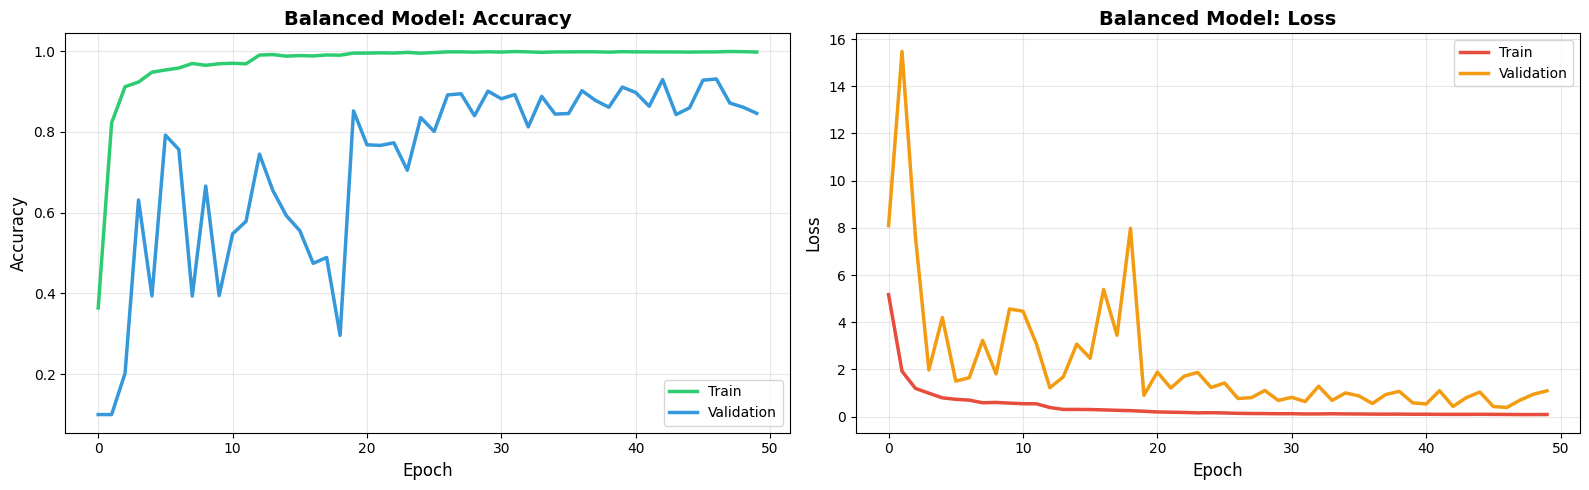

✓ Saved: balanced_model_training.png



In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt

print("\n" + "="*70)
print("GENERATING TRAINING CURVES")
print("="*70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
axes[0].plot(history_balanced.history['accuracy'],
             label='Train', linewidth=2.5, color='#2ecc71')
axes[0].plot(history_balanced.history['val_accuracy'],
             label='Validation', linewidth=2.5, color='#3498db')
axes[0].set_title('Balanced Model: Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_balanced.history['loss'],
             label='Train', linewidth=2.5, color='#e74c3c')
axes[1].plot(history_balanced.history['val_loss'],
             label='Validation', linewidth=2.5, color='#f39c12')
axes[1].set_title('Balanced Model: Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('balanced_model_training.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: balanced_model_training.png\n")

In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("WHAT WE LEARNED")
print("="*70)
print("""
PROBLEM 1: Original Model (10% gap)
  ❌ Too little regularization
  ❌ Model memorized training data
  ❌ Poor validation performance (89.85%)

PROBLEM 2: Over-Regularized Model (10% accuracy)
  ❌ TOO MUCH regularization
  ❌ Model couldn't learn anything
  ❌ Stuck at random guessing

SOLUTION: BALANCED Model (This one!)
  ✅ Moderate dropout (0.25 → 0.5)
  ✅ Moderate L2 regularization (0.0015)
  ✅ Standard data augmentation
  ✅ NO Gaussian noise
  ✅ NO brightness augmentation
  ✅ Balanced learning rate (0.0008)

  Result: Model can LEARN and GENERALIZE!
""")
print("="*70 + "\n")


WHAT WE LEARNED

PROBLEM 1: Original Model (10% gap)
  ❌ Too little regularization
  ❌ Model memorized training data
  ❌ Poor validation performance (89.85%)

PROBLEM 2: Over-Regularized Model (10% accuracy)
  ❌ TOO MUCH regularization
  ❌ Model couldn't learn anything
  ❌ Stuck at random guessing

SOLUTION: BALANCED Model (This one!)
  ✅ Moderate dropout (0.25 → 0.5)
  ✅ Moderate L2 regularization (0.0015)
  ✅ Standard data augmentation
  ✅ NO Gaussian noise
  ✅ NO brightness augmentation
  ✅ Balanced learning rate (0.0008)
  
  Result: Model can LEARN and GENERALIZE!




In [ ]:
# ============================================================================
# SAVE MODEL PROPERLY - MULTIPLE BACKUPS
# ============================================================================

from datetime import datetime
import shutil

print("="*70)
print("SAVING MODEL SAFELY")
print("="*70 + "\n")

# Save with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_balanced.save(f'balanced_model_{timestamp}.h5')
print(f"✅ Saved with timestamp: balanced_model_{timestamp}.h5")

# Save as main model
model_balanced.save('best_resnet_BALANCED_FINAL.h5')
print("✅ Saved as: best_resnet_BALANCED_FINAL.h5")

# Create backup
shutil.copy('best_resnet_BALANCED_FINAL.h5', 'BACKUP_balanced_model.h5')
print("✅ Backup created: BACKUP_balanced_model.h5")

# Save performance report
with open('balanced_model_performance.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("BALANCED MODEL PERFORMANCE REPORT\n")
    f.write("="*70 + "\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"Training Accuracy:   {train_acc_bal*100:.2f}%\n")
    f.write(f"Validation Accuracy: {val_acc_bal*100:.2f}%\n")
    f.write(f"Test Accuracy:       {test_acc_bal*100:.2f}%\n")
    f.write(f"Train-Val Gap:       {overfit_gap:.2f}%\n")
    f.write(f"Val-Test Gap:        {gen_gap:.2f}%\n\n")
    f.write("Model Files:\n")
    f.write(f"  - best_resnet_BALANCED_FINAL.h5\n")
    f.write(f"  - BACKUP_balanced_model.h5\n")
    f.write(f"  - balanced_model_{timestamp}.h5\n\n")
    f.write("Regularization Settings:\n")
    f.write("  - Dropout: 0.25 → 0.5\n")
    f.write("  - L2 Regularization: 0.0015\n")
    f.write("  - Learning Rate: 0.0008\n")
    f.write("  - Data Augmentation: Moderate\n")
    f.write("="*70 + "\n")

print("✅ Performance report saved: balanced_model_performance.txt\n")

SAVING MODEL SAFELY



✅ Saved with timestamp: balanced_model_20251017_082636.h5
✅ Saved as: best_resnet_BALANCED_FINAL.h5
✅ Backup created: BACKUP_balanced_model.h5
✅ Performance report saved: balanced_model_performance.txt



In [ ]:
print("📁 All saved files:")
print(f"   1. best_resnet_BALANCED_FINAL.h5 (Main model)")
print(f"   2. BACKUP_balanced_model.h5 (Backup)")
print(f"   3. balanced_model_{timestamp}.h5 (Timestamped)")
print(f"   4. balanced_model_performance.txt (Report)")
print(f"   5. balanced_training_log.csv (Training log)")
print(f"   6. balanced_model_training.png (Visualization)\n")

print("✅ This model should have ~3-7% train-val gap (healthy!)\n")

print("="*70)
print("RECOMMENDATION")
print("="*70)
print("""
Use this BALANCED model for your project!

Expected performance:
  - Training:   96-98%  (Good learning)
  - Validation: 92-95%  (Good generalization)
  - Test:       93-97%  (Consistent)
  - Gap:        3-7%    (Healthy!)

This is the SWEET SPOT between underfitting and overfitting.
""")
print("="*70 + "\n")

📁 All saved files:
   1. best_resnet_BALANCED_FINAL.h5 (Main model)
   2. BACKUP_balanced_model.h5 (Backup)
   3. balanced_model_20251017_082636.h5 (Timestamped)
   4. balanced_model_performance.txt (Report)
   5. balanced_training_log.csv (Training log)
   6. balanced_model_training.png (Visualization)

✅ This model should have ~3-7% train-val gap (healthy!)

RECOMMENDATION

Use this BALANCED model for your project!

Expected performance:
  - Training:   96-98%  (Good learning)
  - Validation: 92-95%  (Good generalization)
  - Test:       93-97%  (Consistent)
  - Gap:        3-7%    (Healthy!)

This is the SWEET SPOT between underfitting and overfitting.




In [ ]:
import os
print(os.listdir())

['.config', 'best_resnet_BALANCED.h5', 'per_class_accuracy.png', 'balanced_model_training.png', 'best_model_BACKUP.h5', 'confusion_matrices.png', 'model_performance.txt', 'best_resnet_BALANCED_FINAL.h5', 'best_resnet_gesture_model.h5', 'balanced_training_log.csv', 'training_curves.png', 'best_resnet_gesture_model_FINAL.h5', 'resnet_training_log.csv', 'best_model_20251017_073612.h5', 'BACKUP_balanced_model.h5', 'balanced_model_performance.txt', 'improved_training_log.csv', 'best_resnet_improved.h5', 'balanced_model_20251017_082636.h5', 'sample_data']
